In [5]:
import pandas as pd
# import modin.pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

from sklearn.metrics import confusion_matrix,classification_report,precision_score,\
auc, precision_recall_curve, roc_curve
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer


import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout, MaxPooling2D
from keras import optimizers
from keras import metrics as kmetr
from tensorflow.keras.utils import plot_model

import pydot

In [6]:
#### test & train split
data = pd.read_csv('../saved F(Drug-Disease).csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../saved F(Drug-Disease).csv'

In [10]:
# data.iloc[:int(0.9*len(data.iloc[:,2])),:].to_csv('../trainSaved F(Drug-Disease).csv',index=False)
# data.iloc[int(0.9*len(data.iloc[:,2])):,:].to_csv('../testSaved F(Drug-Disease).csv',index=False)
                 
# del data

In [11]:
# dataTrain = pd.read_csv('../trainSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../testSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../../triple_cosineSNF(zeros).csv')
# print(dataTest.shape,dataTrain.shape)

In [12]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True)

In [59]:
dataTrain = data.iloc[int(0.3*len(data.iloc[:,2])):,:]
dataTest = data.iloc[:int(0.3*len(data.iloc[:,2])),:]

In [15]:
X_train = dataTrain.values[:,3:]
y_train = dataTrain.values[:,2].astype(int)
trainNum = len(X_train)
del dataTrain

X_test = dataTest.values[:,3:]
y_test = dataTest.values[:,2].astype(int)
testNum = len(X_test)
del data

transformer = Normalizer().fit(X_train)  # fit does nothing.
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)


#reshape data to fit model
X_train = X_train.reshape(trainNum,16,67,1)
X_test = X_test.reshape(testNum,16,67,1)

# y_train = y_train + 1
# y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
# print(y_train[0:5], y_test[0:5])

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# y_test[0]


In [45]:
# #create model
# model = Sequential()
# #add model layers
# model.add(Conv2D(128, kernel_size=4, activation='relu', input_shape=(16,71,1)))
# # model.add(Conv2D(64, kernel_size=2, activation='relu'))

# model.add(Conv2D(32, kernel_size=4, activation='relu'))
# # model.add(Conv2D(16, kernel_size=2, activation='relu'))
# model.add(Conv2D(8, kernel_size=4, activation='relu'))
# model.add(Flatten())
# # model.add(Dense( 64, activation='relu'))
# model.add(Dense( 32, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dropout(0.4))
# # model.add(Dense( 16, activation='relu'))
# model.add(Dense( 8, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense( 2, activation='sigmoid'))
# # model.add(Softmax(128))
# model.summary()

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=4, activation='relu',\
                 input_shape=(16,67,1), padding='same'))
# model.add(Conv2D(64, kernel_size=4, activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=4, activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=4, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dense( 32, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense( 16, activation='relu'))
model.add(Dense(2, activation='relu'))
# model.add(Softmax(128))
model.summary()


adam = optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy',\
              metrics=['categorical_accuracy']) ## Minist

### Load the model's saved weights.
# model.load_weights('cnn_4_epoch.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 16, 67, 64)        1088      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 67, 32)        32800     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 67, 16)        8208      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 33, 16)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 5, 30, 8)          2056      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)               

In [46]:
# #### plotting model
# plot_model(model,show_shapes = True, to_file='model .png')

In [47]:
#### train the model

#compile model using accuracy to measure model performance
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
class_weight = {0: 5,
                1: 95
               }


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, class_weight=class_weight)
# history = model.fit(X_train, y_train, epochs=1)


Train on 189817 samples, validate on 81350 samples
Epoch 1/4
189817/189817 [==============================] - 1401s 7ms/step - loss: 14.6184 - categorical_accuracy: 0.9904 - val_loss: 0.1427 - val_categorical_accuracy: 0.9911
Epoch 2/4
189817/189817 [==============================] - 1406s 7ms/step - loss: 14.6171 - categorical_accuracy: 0.9905 - val_loss: 0.1427 - val_categorical_accuracy: 0.9911
Epoch 3/4
189817/189817 [==============================] - 1400s 7ms/step - loss: 14.6171 - categorical_accuracy: 0.9905 - val_loss: 0.1427 - val_categorical_accuracy: 0.9911
Epoch 4/4
189817/189817 [==============================] - 1399s 7ms/step - loss: 14.6171 - categorical_accuracy: 0.9905 - val_loss: 0.1427 - val_categorical_accuracy: 0.9911


In [48]:
### Saveing the Model
model.save_weights('cnn_3_epoch.h5')


In [49]:
predit = model.predict(X_test)
#actual results for first 4 images in test set
print(predit[:4])


[[145.46114   0.     ]
 [145.57721   0.     ]
 [145.29405   0.     ]
 [145.33064   0.     ]]


In [50]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,1], predit[:,1])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,1], predit[:,1])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val)

0.5044253226797787 0.5


In [51]:
model.history.history

{'val_loss': [0.14265565011423648,
  0.14265565011423648,
  0.14265565011423648,
  0.14265565011423648],
 'val_categorical_accuracy': [0.9911493546404425,
  0.9911493546404425,
  0.9911493546404425,
  0.9911493546404425],
 'loss': [14.618393609836616,
  14.617073911984534,
  14.617075331891382,
  14.617073914717686],
 'categorical_accuracy': [0.9903960130019966,
  0.9904539635543708,
  0.9904539635515447,
  0.9904539635543708]}

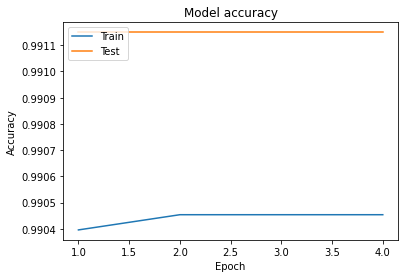

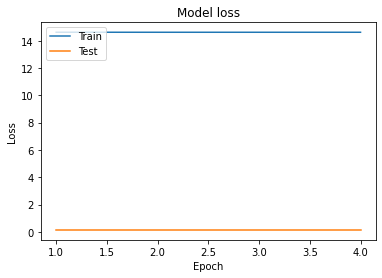

In [53]:

# Plot training & validation accuracy values
plt.plot(list(range(1,5)),model.history.history['categorical_accuracy'])
plt.plot(list(range(1,5)),model.history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(list(range(1,5)),model.history.history['loss'])
plt.plot(list(range(1,5)),model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
# # predit
# predit[:,0].shape 

In [55]:
predicts = []
for a,b in predit:
    if a >=b:
        predicts.append(0)
    else:
        predicts.append(1)
len(predicts)

81350

In [56]:
# predicts1 = []
# e = d = z = 0

# for a,b in predit:
#     if a >=0.90:
#         predicts1.append(0)
#         d += 1
#     elif b>=0.95:
#         predicts1.append(2)
#         e += 1
#     elif a<=0.05 and b<=0.1:
#         predicts1.append(1)
#         z += 1
# print('degrassive', d, 'enhancive', e, 'zeros', z)
# print("""
# Epoch04: degrassive 224 enhancive 2939 zeros 40
# Epoch05: degrassive 280 enhancive 2823 zeros 39
# Epoch06: degrassive 233 enhancive 2879 zeros 79
# Epoch07: degrassive 203 enhancive 2926 zeros 134
# Epoch08: degrassive 224 enhancive 2895 zeros 180
# Epoch09: degrassive 191 enhancive 2856 zeros 191
# Epoch10: degrassive 189 enhancive 2821 zeros 246
# Epoch11: degrassive 164 enhancive 2581 zeros 235
# Epoch12: degrassive 166 enhancive 2454 zeros 266
# """)

In [57]:
# max(list((dataTest.values[:,2]+1)/2))

[[80630   720]
 [    0     0]]


/home/amin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     80630
           1       0.00      0.00      0.00       720

    accuracy                           0.99     81350
   macro avg       0.50      0.50      0.50     81350
weighted avg       0.98      0.99      0.99     81350



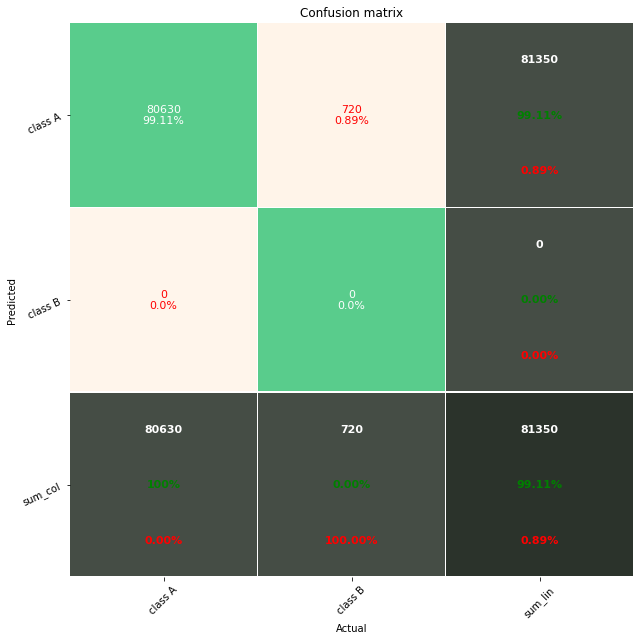

In [60]:

cm = confusion_matrix(list(predicts), list((dataTest.values[:,2])))
print(cm)

CR = classification_report(list((dataTest.values[:,2])),list(predicts))
print(CR)
# print(145/4702)
# i=0
# for j in list(data.values[9500:,2]+1):
#     if j==1:
#         i +=1
# print(i)

# plt.show()
plot_confusion_matrix_from_data(list((dataTest.values[:,2])), list(predicts))


In [61]:
print(pd.DataFrame(predit))

                0    1
0      145.461136  0.0
1      145.577209  0.0
2      145.294052  0.0
3      145.330643  0.0
4      144.953934  0.0
...           ...  ...
81345  147.140991  0.0
81346  146.799026  0.0
81347  145.129105  0.0
81348  146.188263  0.0
81349  147.192993  0.0

[81350 rows x 2 columns]


LinAlgError: singular matrix

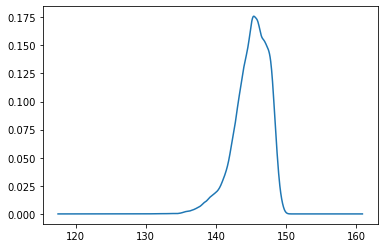

In [62]:
pd.DataFrame(predit).plot.density()


<AxesSubplot:ylabel='Density'>

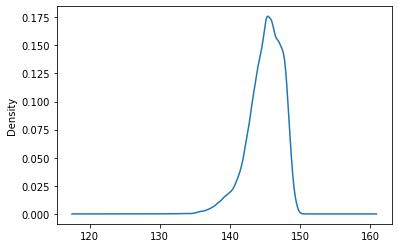

In [63]:
pd.DataFrame(predit).iloc[:,0].plot.density()

LinAlgError: singular matrix

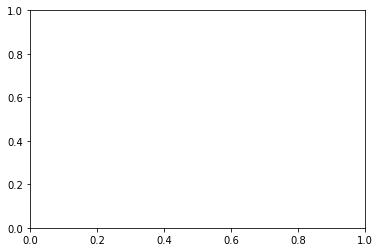

In [64]:
pd.DataFrame(predit).iloc[:,1].plot.density()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Interaction drugs Probability')
plt.ylabel('frequency distribution')


In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('None Interaction drugs Probability')
plt.ylabel('frequency distribution')

In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('all drugs Probability')
plt.ylabel('frequency distribution')